In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import helpers as hp

In [3]:
tf.get_logger().setLevel(logging.ERROR)

In [4]:
commands, nums = hp.get_commands_dict('commands.csv')

In [5]:
all_speakers = ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
dataset = dict()
for speaker in all_speakers:
    data = hp.load_from_datafile(f'data/{speaker}_data.npy')
    labels = hp.load_from_datafile(f'data/{speaker}_labels.npy')

    data = data.reshape(data.shape + (1,))
    labels = to_categorical([hp.get_num_by_command(label, commands) for label in labels], num_classes=11)
    idx = np.random.permutation(data.shape[0])
    data, labels = data[idx], labels[idx]
    
    dataset[speaker] = {
        'data':   data,
        'labels': labels 
    }
    
    print(f'{speaker} data shape: {dataset[speaker]["data"].shape}')
    print(f'{speaker} labels shape: {dataset[speaker]["labels"].shape}')

speaker1 data shape: (550, 400, 13, 1)
speaker1 labels shape: (550, 11)
speaker2 data shape: (440, 400, 13, 1)
speaker2 labels shape: (440, 11)
speaker3 data shape: (440, 400, 13, 1)
speaker3 labels shape: (440, 11)
speaker4 data shape: (440, 400, 13, 1)
speaker4 labels shape: (440, 11)
speaker5 data shape: (550, 400, 13, 1)
speaker5 labels shape: (550, 11)
speaker6 data shape: (550, 400, 13, 1)
speaker6 labels shape: (550, 11)


In [6]:
test_size = 0.3
cnn_test_summary = []
mlp_test_summary = []
threshold_list = [0.5, 0.6, 0.7, 0.8]

In [7]:
def run_experiment(train_list, test_list, nn_type, threshold_list, plot_cm=True):
    print(f'Running experiment with speakers : {train_list} as train dataset and speakers : {test_list} as test dataset.',
          f'Network type is {nn_type}.')
    # Set train data
    train_data = []
    train_labels = []
    for speaker in train_list:
        train_data.append(dataset[speaker]['data'][:np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int), ...])
        train_labels.append(dataset[speaker]['labels'][:np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int), ...])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Set test data
    test_dict = dict()
    for speaker in test_list:
        test_dict[speaker] = {
            'data': dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...] ,
            'labels': dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...]
        }

    print('---Train dataset---')
    print(f'Contains speakers : {train_list}')
    print(f'data shape : {train_data.shape}')
    print(f'labels shape : {train_labels.shape}')
    
    print('---Test dataset---')
    print(f'Contains speakers : {test_list}')
    for speaker in test_list:
        print(f'{speaker} data shape : {test_dict[speaker]["data"].shape}')
        print(f'{speaker} labels shape : {test_dict[speaker]["labels"].shape}')
    
    # Train
    if nn_type == 'mlp':
        model = hp.get_mlp_model()
    elif nn_type == 'cnn':
        model = hp.get_cnn_model()
        
    model.summary()
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_best_only = ModelCheckpoint(save_freq='epoch', save_best_only=True,
                                           filepath='model_checkpoints/experiment2/' + nn_type + '/best_only', verbose=0) 
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

    print('---Training stage---')
    history = model.fit(train_data, train_labels, epochs=50, batch_size=256, validation_split=0.15, 
                        callbacks=[early_stopping, checkpoint_best_only], 
                        verbose=0)

    hp.plot_metrics(history)
    
    # Test
    print('---Testing stage---')
    for speaker in test_list:
        test_loss, test_accuracy = model.evaluate(test_dict[speaker]['data'], test_dict[speaker]['labels'], verbose=0)
        print(f"{speaker} - test loss : {test_loss:0.3f} - test accuracy : {test_accuracy:0.3f}")
        
        if nn_type == 'cnn':
            cnn_test_summary.append([train_list, speaker, round(test_loss, 3), round(test_accuracy, 3)])   
        else:
            mlp_test_summary.append([train_list, speaker, round(test_loss, 3), round(test_accuracy, 3)])
        if plot_cm:
            for threshold in threshold_list:
                print(f'Threshold : {threshold}')
                confusion_matrix = hp.get_confusion_matrix(test_dict[speaker]['labels'], model.predict(test_dict[speaker]['data']), nums, threshold=threshold)
                hp.plot_confusion_matrix(confusion_matrix)
        
        print('-'*10)
    print('Finished experiment.')
    print('='*10)       

Running experiment with speakers : ['speaker1'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Par

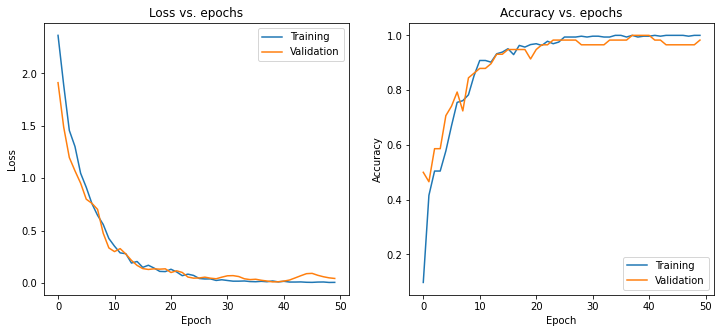

---Testing stage---
speaker1 - test loss : 0.096 - test accuracy : 0.964
----------
speaker2 - test loss : 15.787 - test accuracy : 0.174
----------
speaker3 - test loss : 6.800 - test accuracy : 0.280
----------
speaker4 - test loss : 17.862 - test accuracy : 0.076
----------
speaker5 - test loss : 2.951 - test accuracy : 0.636
----------
speaker6 - test loss : 24.729 - test accuracy : 0.145
----------
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape 

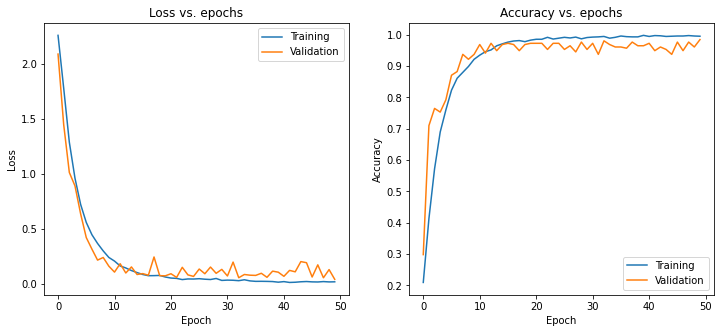

---Testing stage---
speaker1 - test loss : 0.025 - test accuracy : 0.988
Threshold : 0.5


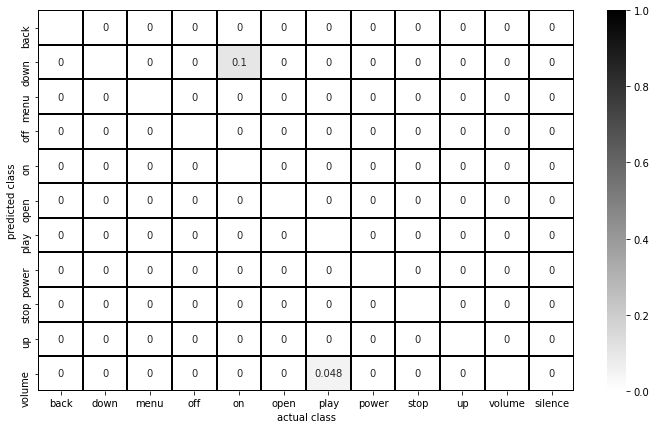

Threshold : 0.6


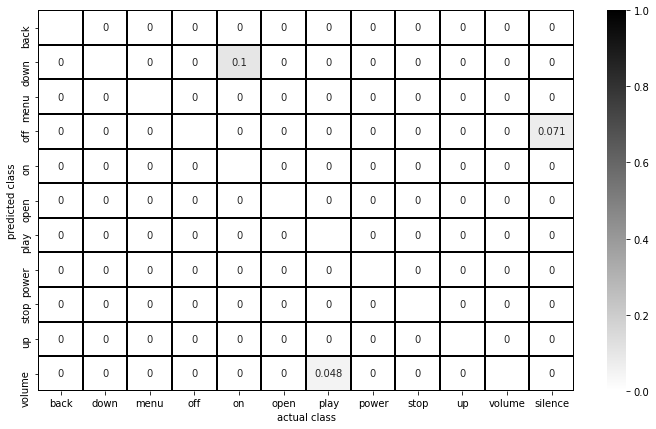

Threshold : 0.7


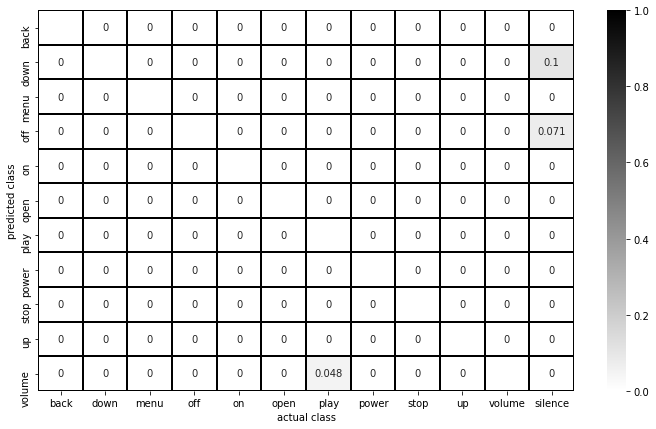

Threshold : 0.8


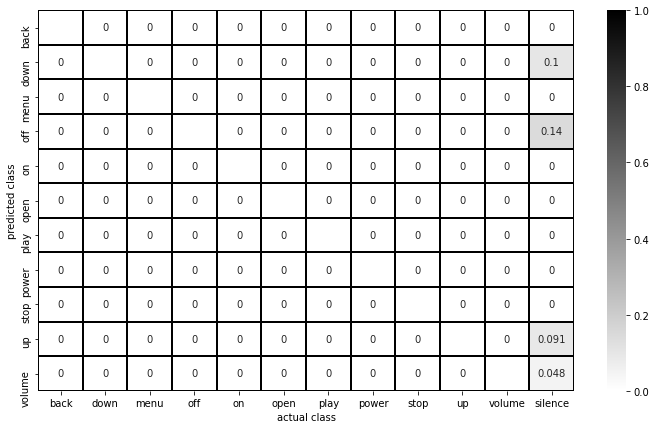

----------
speaker2 - test loss : 0.101 - test accuracy : 0.970
Threshold : 0.5


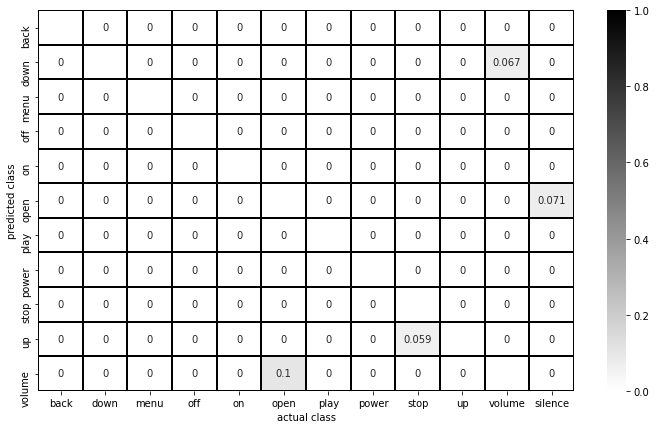

Threshold : 0.6


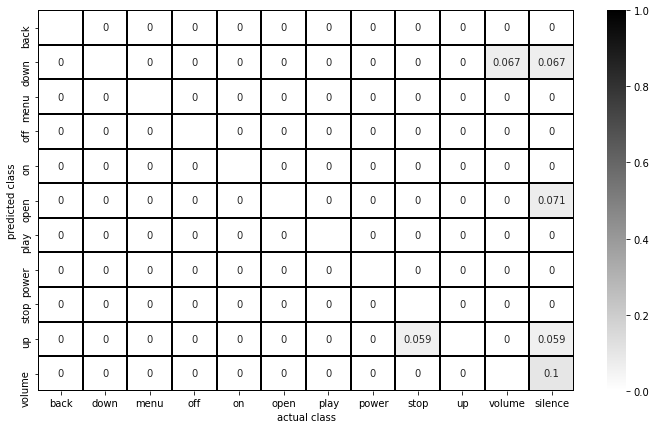

Threshold : 0.7


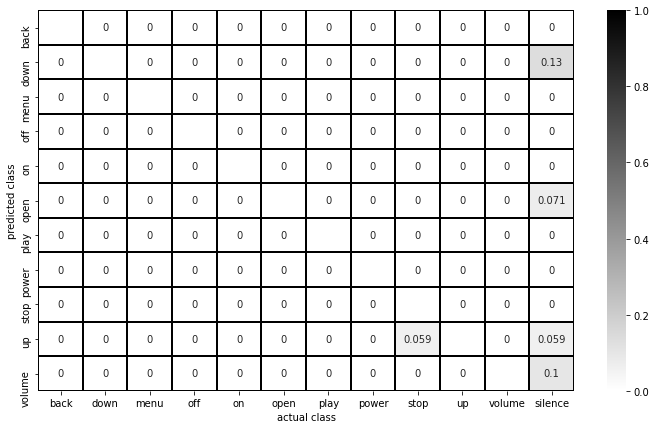

Threshold : 0.8


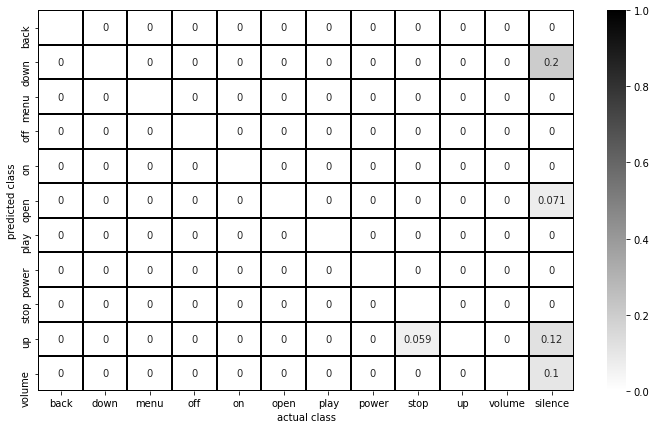

----------
speaker3 - test loss : 0.053 - test accuracy : 0.992
Threshold : 0.5


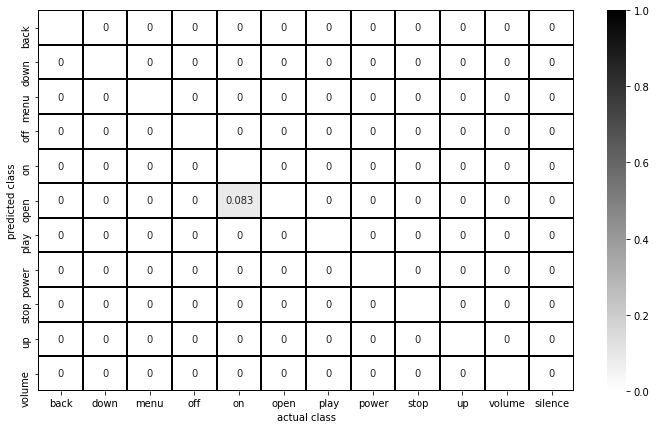

Threshold : 0.6


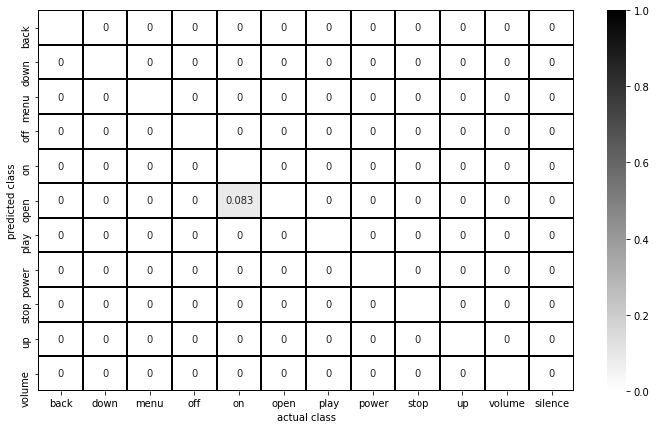

Threshold : 0.7


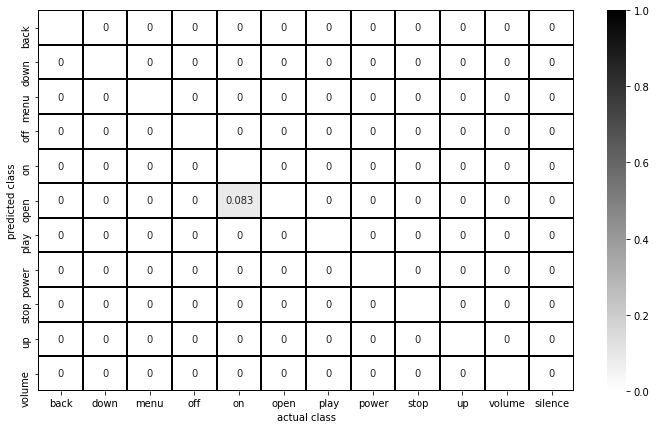

Threshold : 0.8


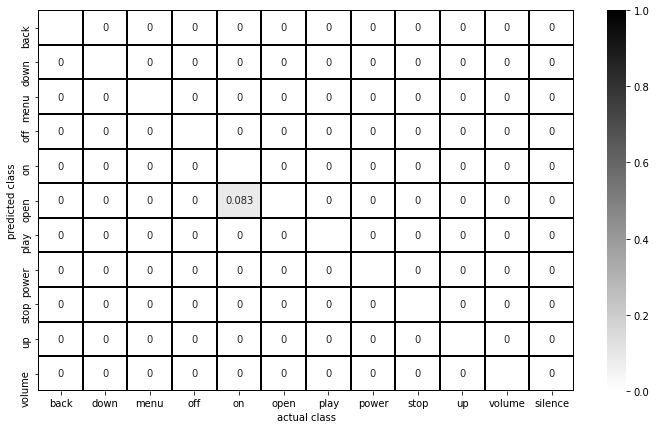

----------
speaker4 - test loss : 1.212 - test accuracy : 0.894
Threshold : 0.5


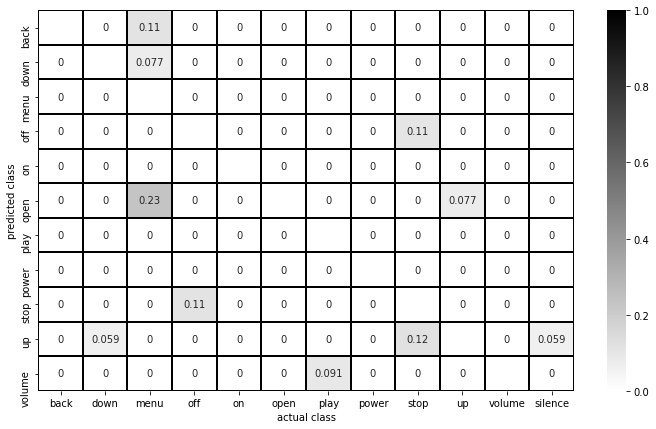

Threshold : 0.6


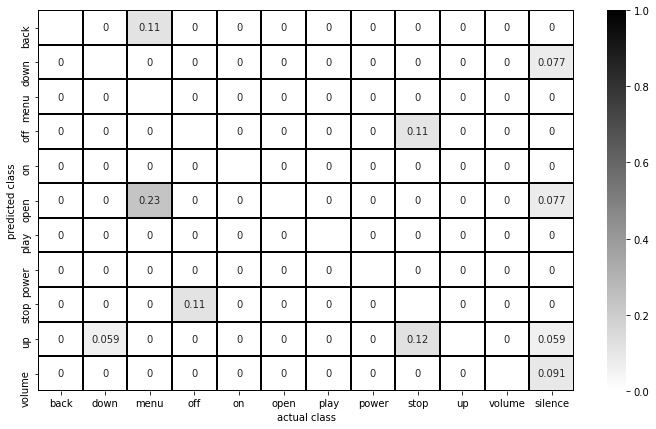

Threshold : 0.7


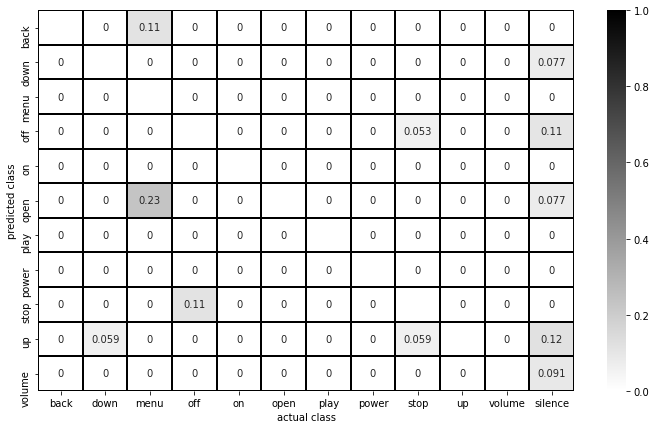

Threshold : 0.8


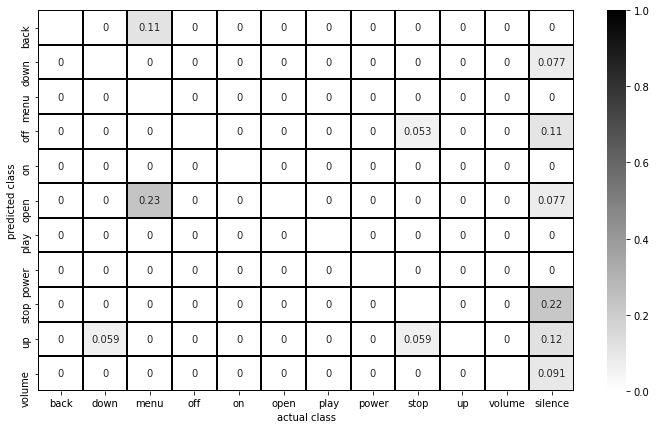

----------
speaker5 - test loss : 0.071 - test accuracy : 0.976
Threshold : 0.5


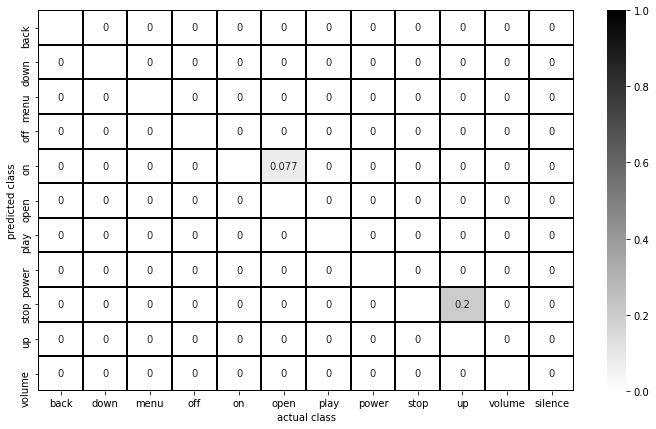

Threshold : 0.6


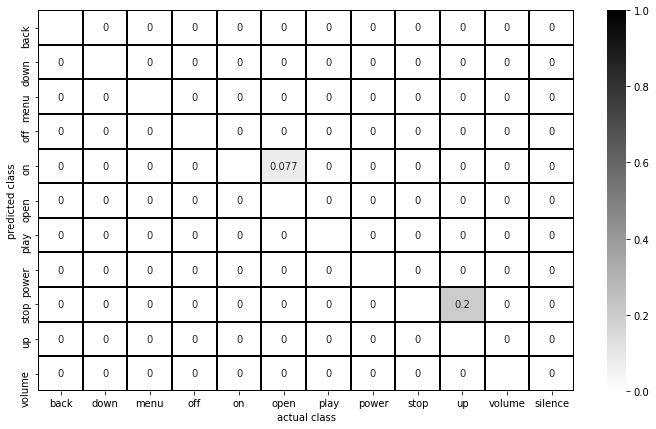

Threshold : 0.7


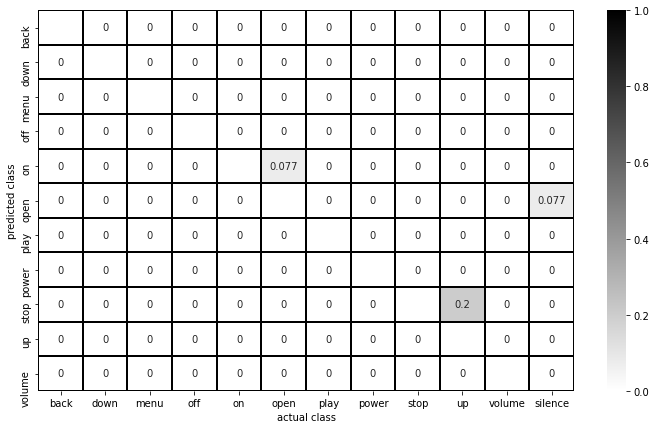

Threshold : 0.8


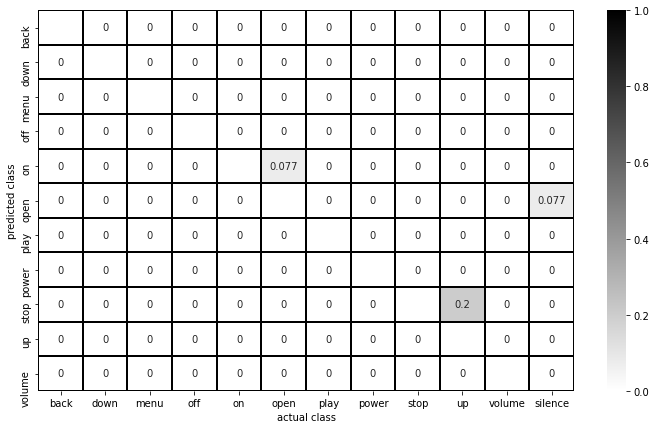

----------
speaker6 - test loss : 8.773 - test accuracy : 0.394
Threshold : 0.5


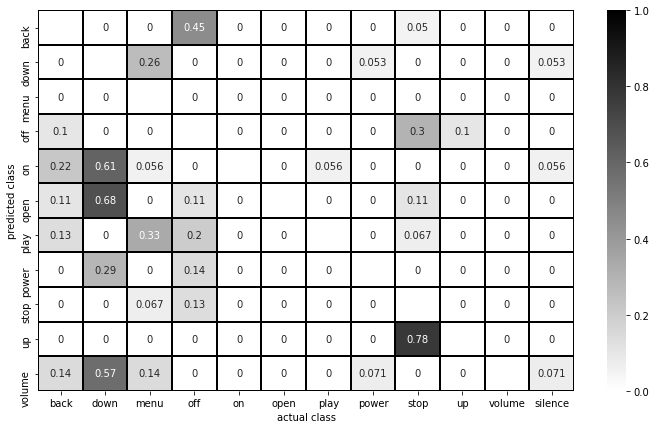

Threshold : 0.6


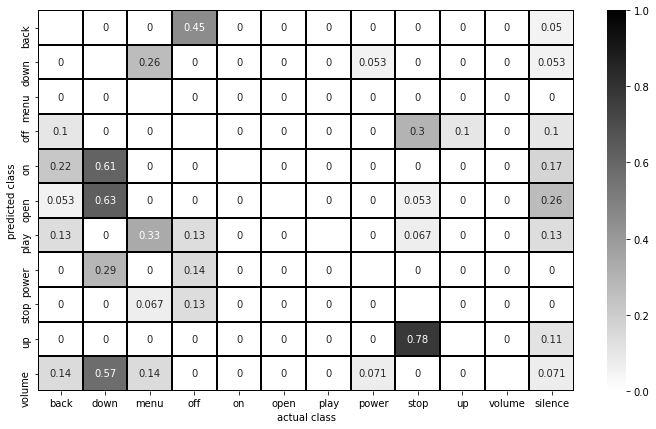

Threshold : 0.7


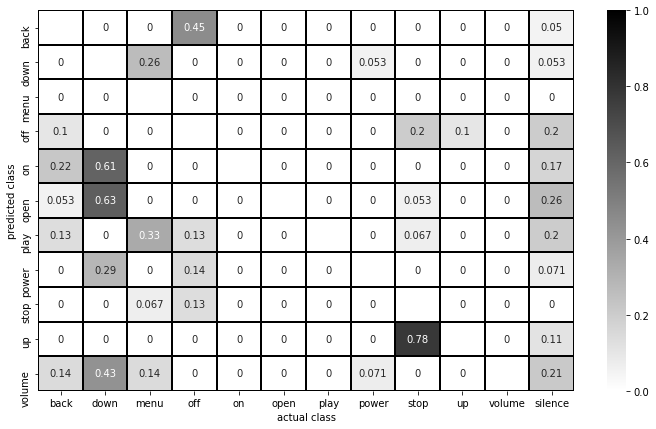

Threshold : 0.8


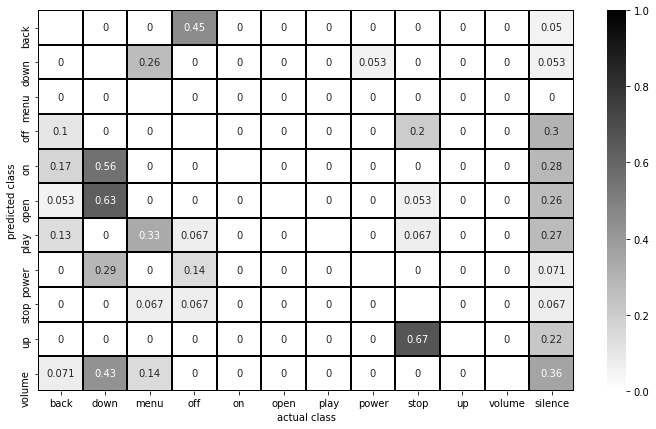

----------
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : 

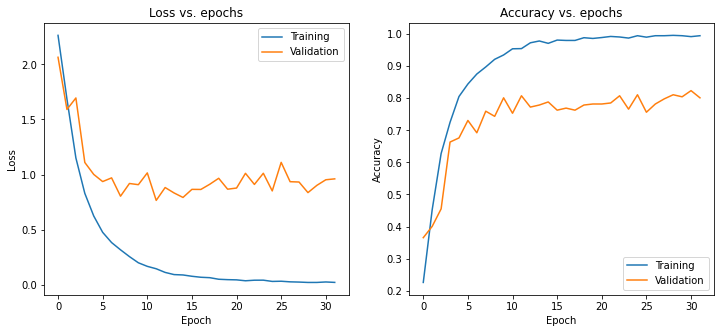

---Testing stage---
speaker1 - test loss : 0.045 - test accuracy : 0.988
Threshold : 0.5


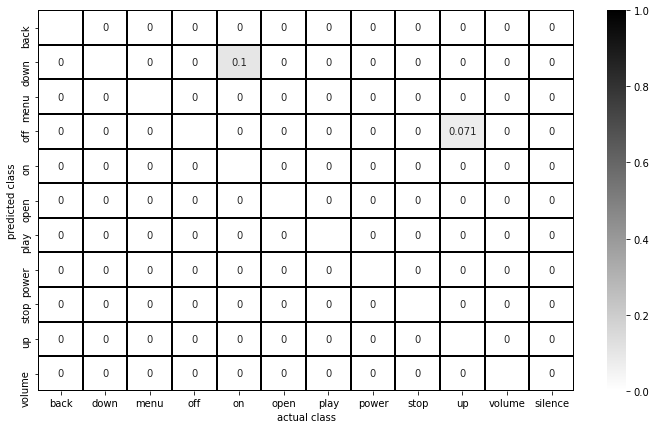

Threshold : 0.6


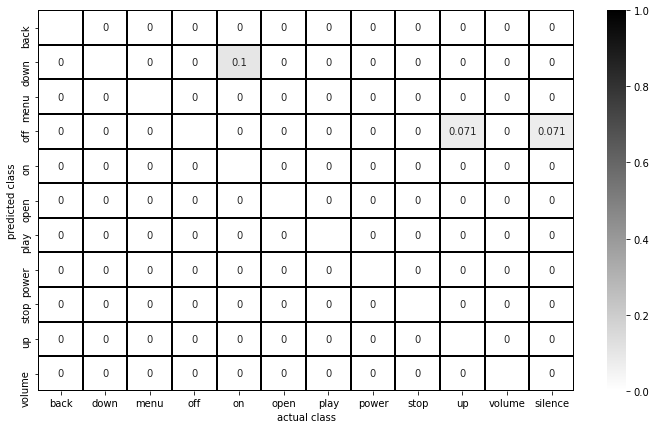

Threshold : 0.7


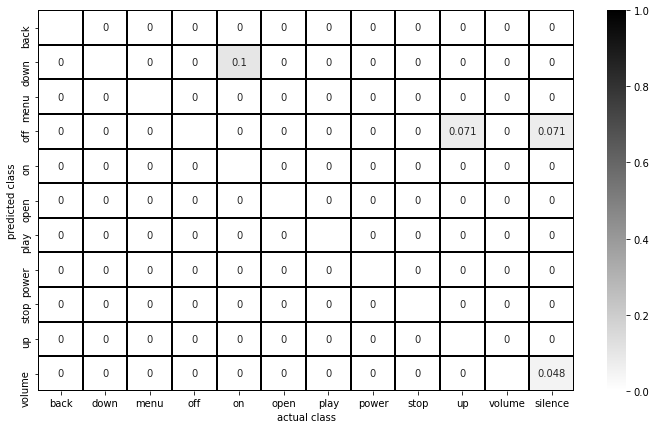

Threshold : 0.8


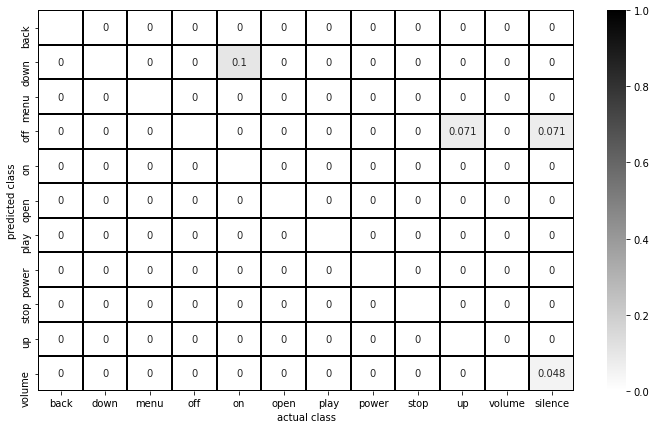

----------
speaker2 - test loss : 0.134 - test accuracy : 0.955
Threshold : 0.5


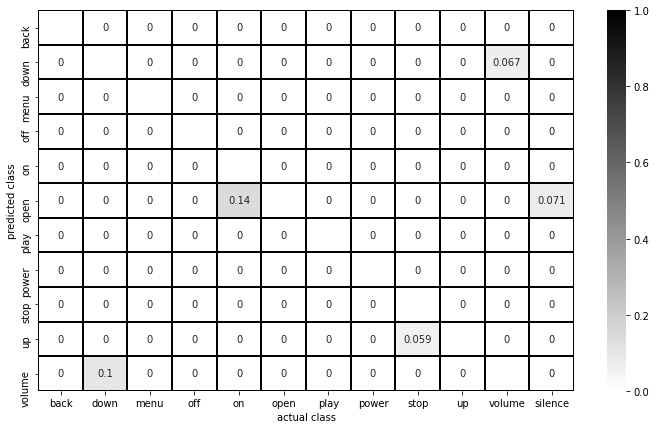

Threshold : 0.6


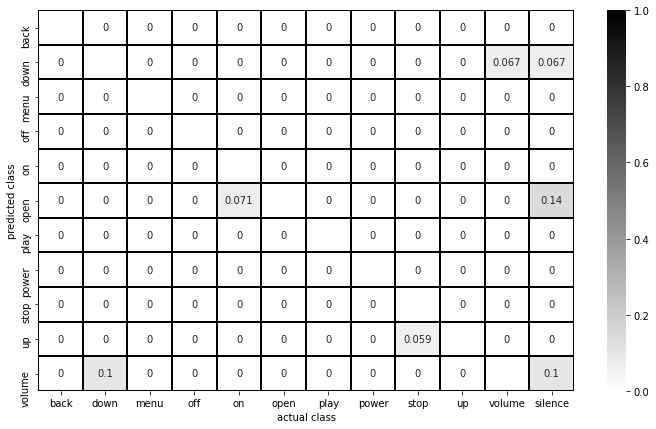

Threshold : 0.7


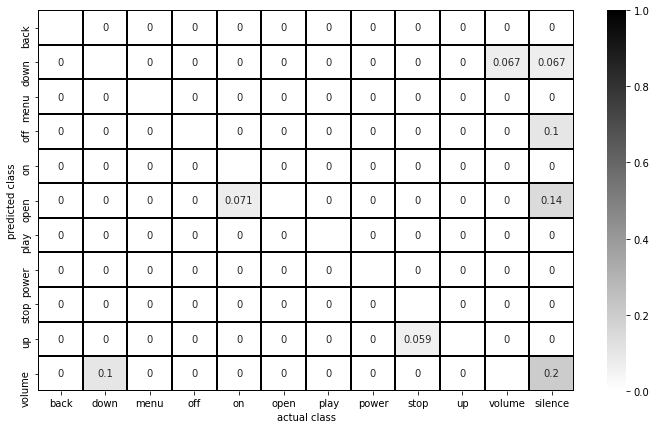

Threshold : 0.8


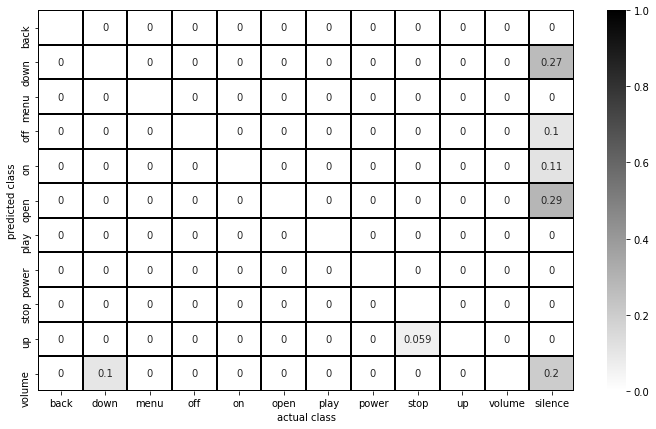

----------
speaker3 - test loss : 0.100 - test accuracy : 0.977
Threshold : 0.5


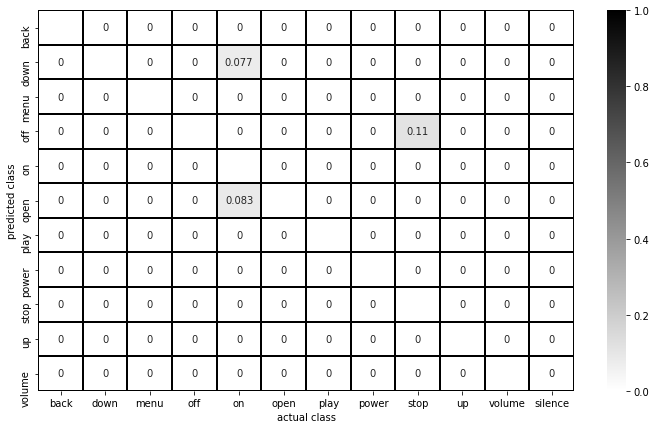

Threshold : 0.6


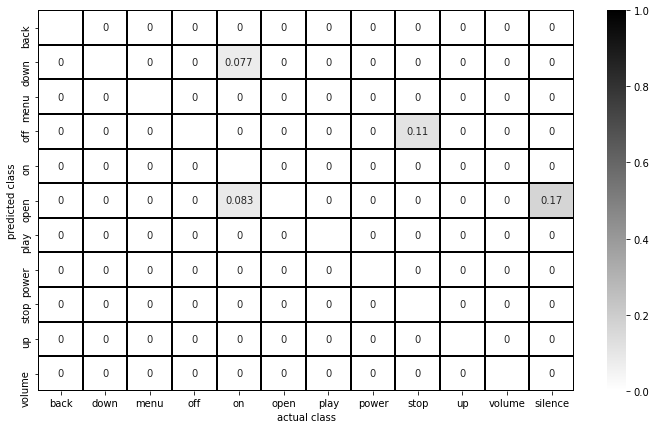

Threshold : 0.7


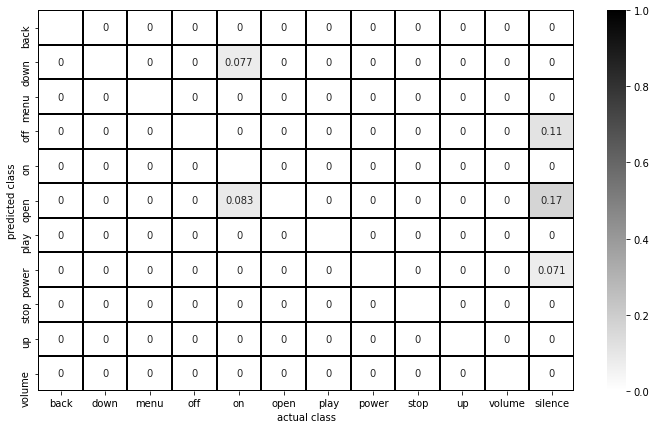

Threshold : 0.8


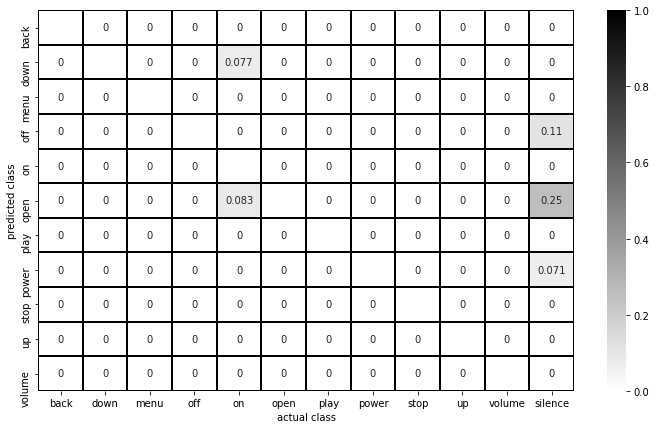

----------
speaker4 - test loss : 0.784 - test accuracy : 0.879
Threshold : 0.5


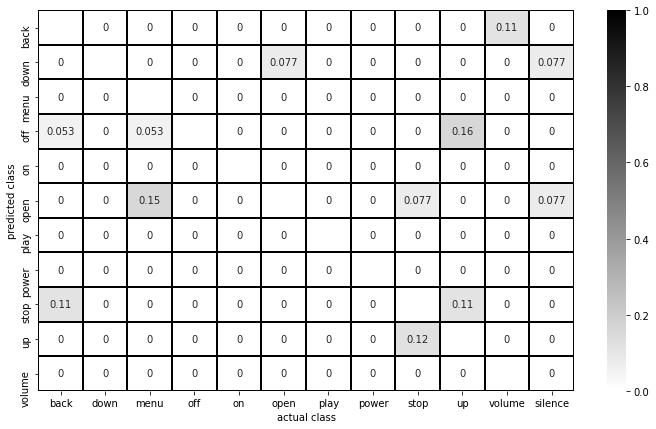

Threshold : 0.6


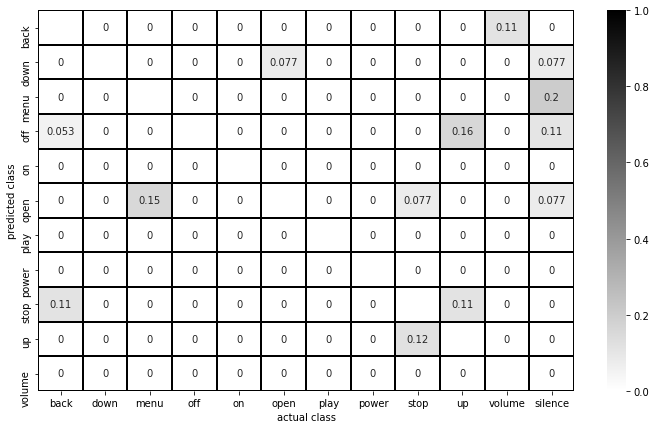

Threshold : 0.7


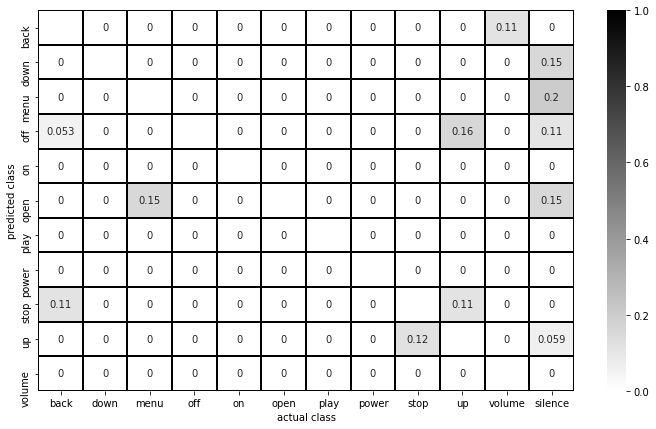

Threshold : 0.8


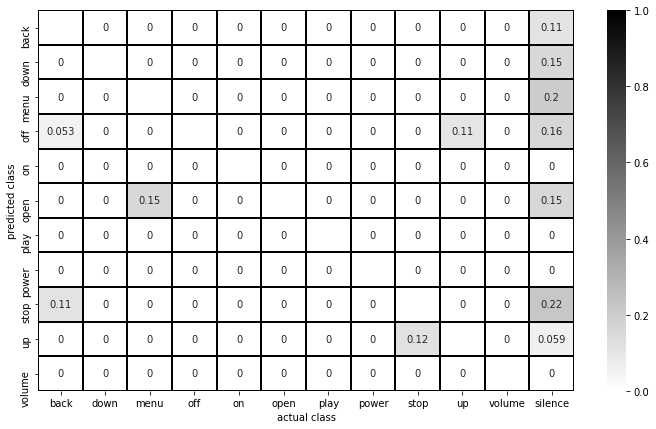

----------
speaker5 - test loss : 0.015 - test accuracy : 0.988
Threshold : 0.5


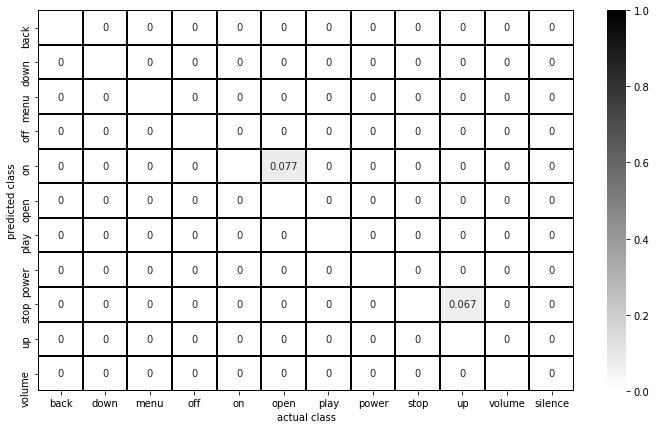

Threshold : 0.6


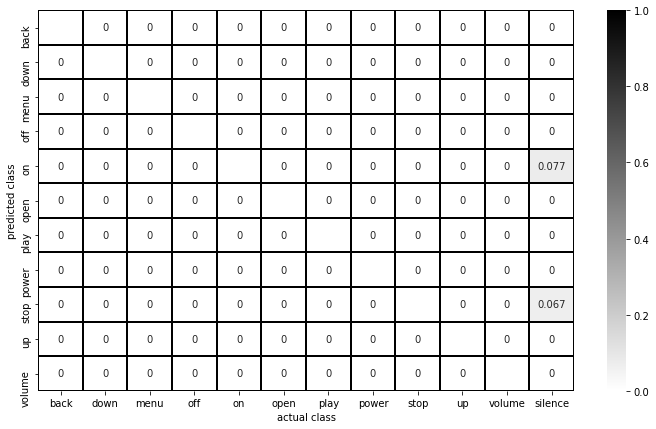

Threshold : 0.7


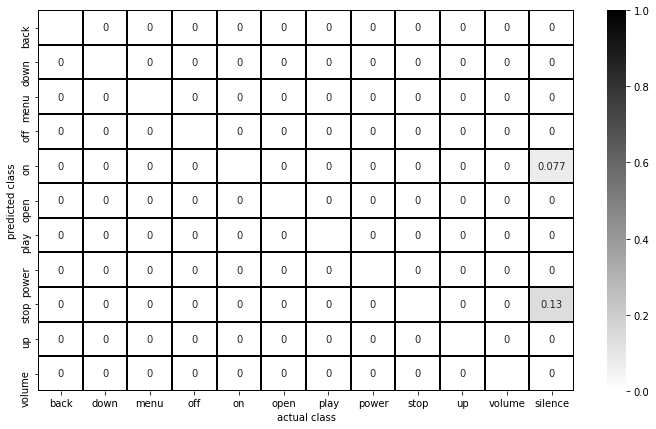

Threshold : 0.8


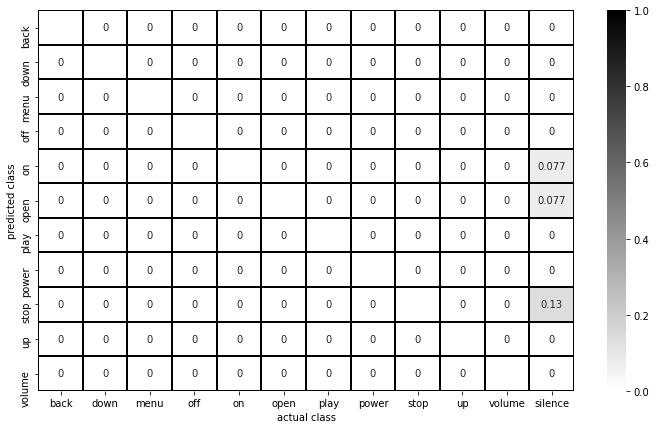

----------
speaker6 - test loss : 0.975 - test accuracy : 0.824
Threshold : 0.5


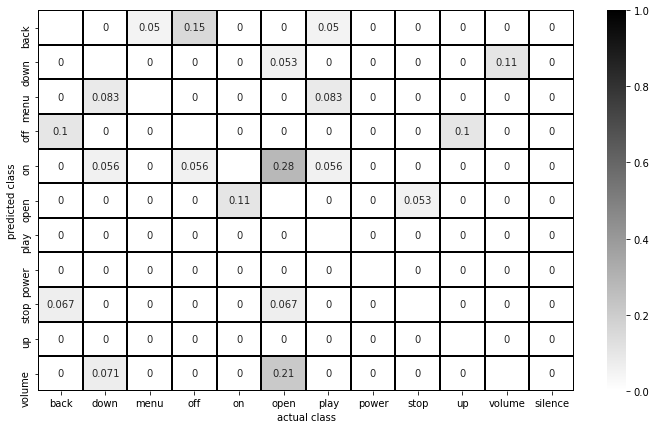

Threshold : 0.6


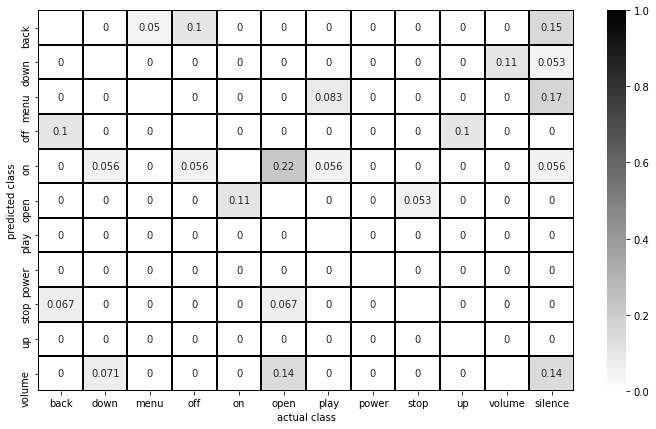

Threshold : 0.7


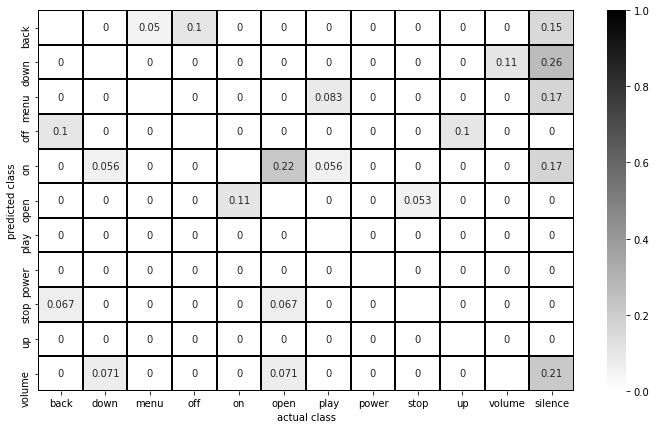

Threshold : 0.8


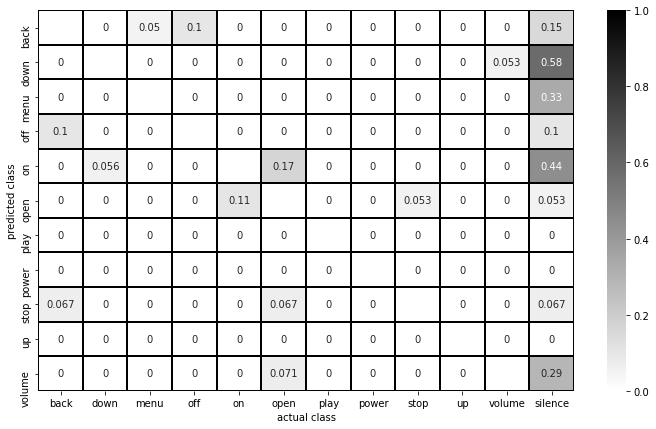

----------
Finished experiment.
Running experiment with speakers : ['speaker1'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
Model: "sequential_3"
_________________________________________________________________
Layer (type)            

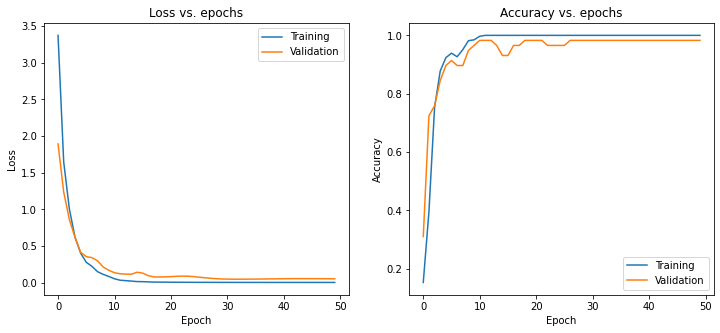

---Testing stage---
speaker1 - test loss : 0.096 - test accuracy : 0.964
----------
speaker2 - test loss : 8.212 - test accuracy : 0.159
----------
speaker3 - test loss : 2.900 - test accuracy : 0.432
----------
speaker4 - test loss : 7.211 - test accuracy : 0.250
----------
speaker5 - test loss : 3.211 - test accuracy : 0.606
----------
speaker6 - test loss : 9.221 - test accuracy : 0.145
----------
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (

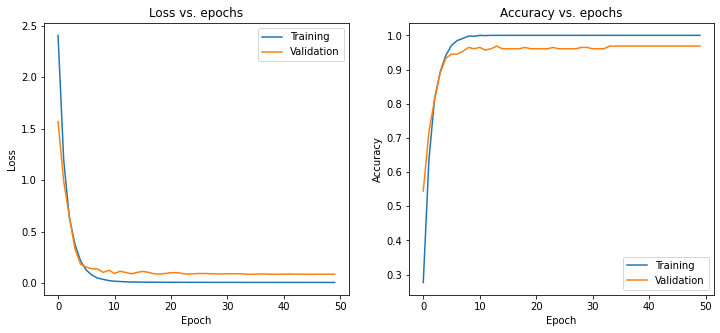

---Testing stage---
speaker1 - test loss : 0.081 - test accuracy : 0.970
Threshold : 0.5


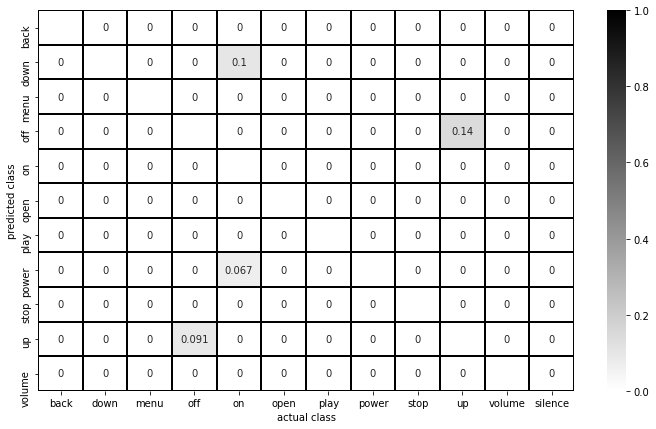

Threshold : 0.6


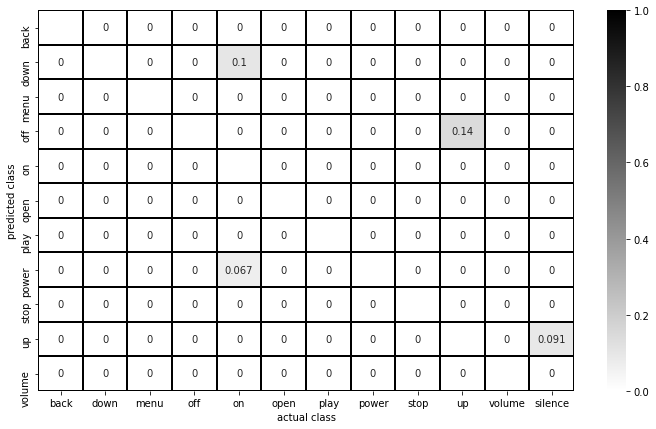

Threshold : 0.7


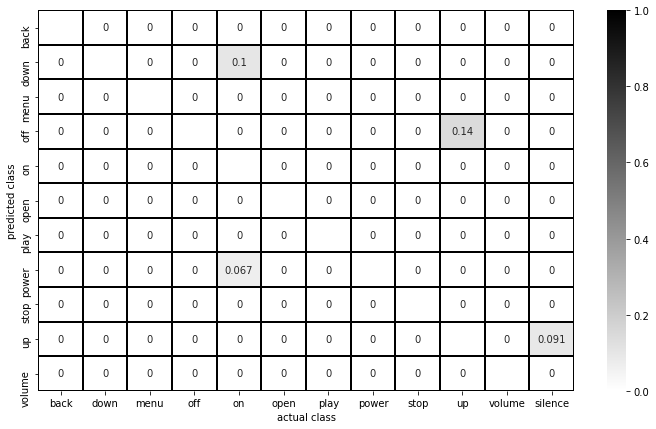

Threshold : 0.8


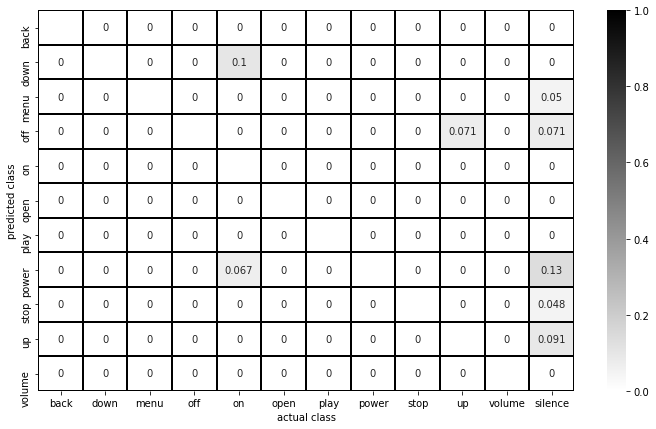

----------
speaker2 - test loss : 0.410 - test accuracy : 0.886
Threshold : 0.5


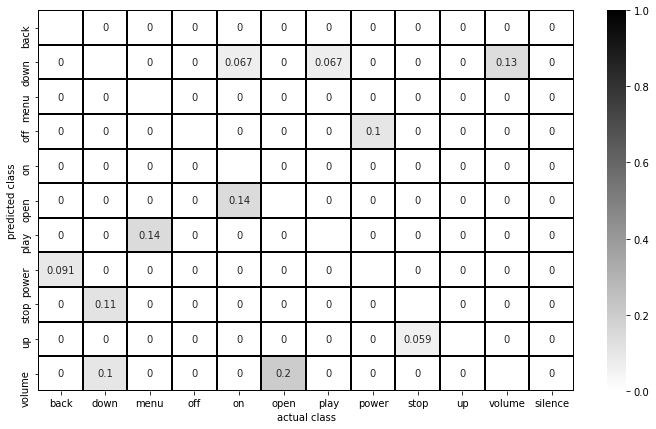

Threshold : 0.6


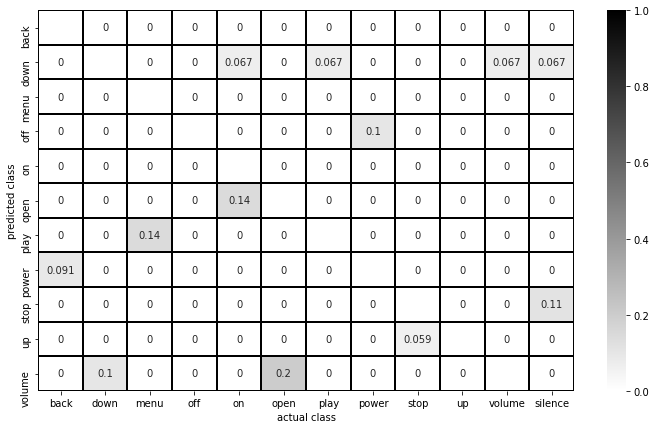

Threshold : 0.7


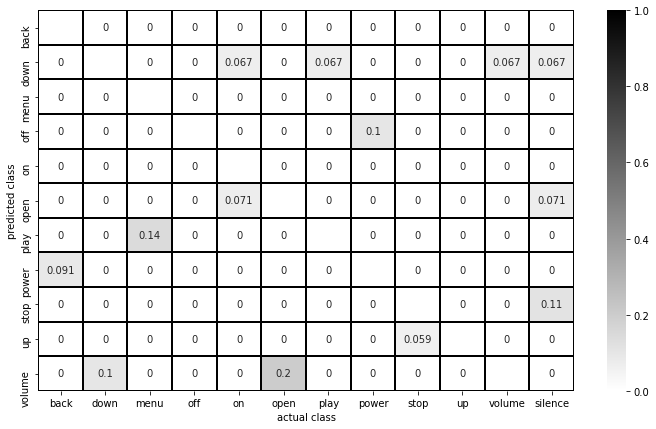

Threshold : 0.8


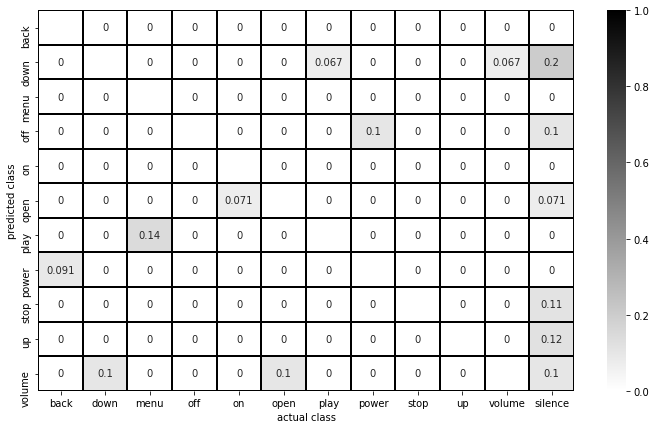

----------
speaker3 - test loss : 0.068 - test accuracy : 0.985
Threshold : 0.5


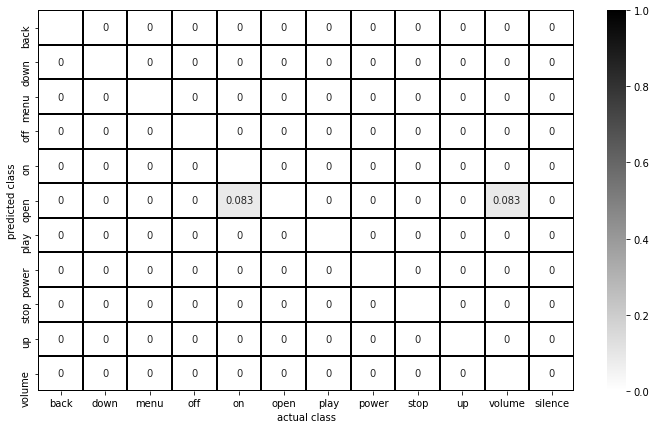

Threshold : 0.6


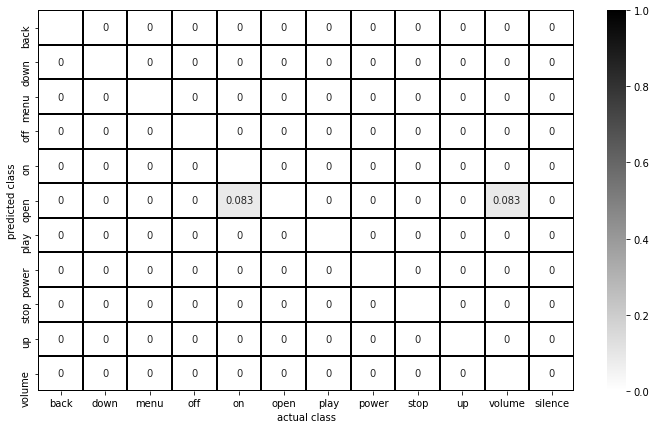

Threshold : 0.7


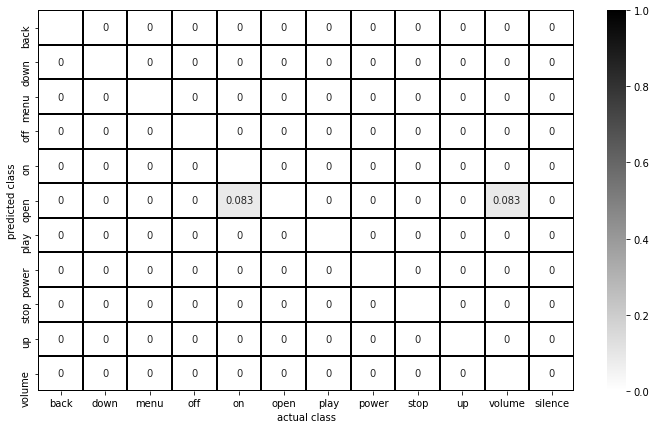

Threshold : 0.8


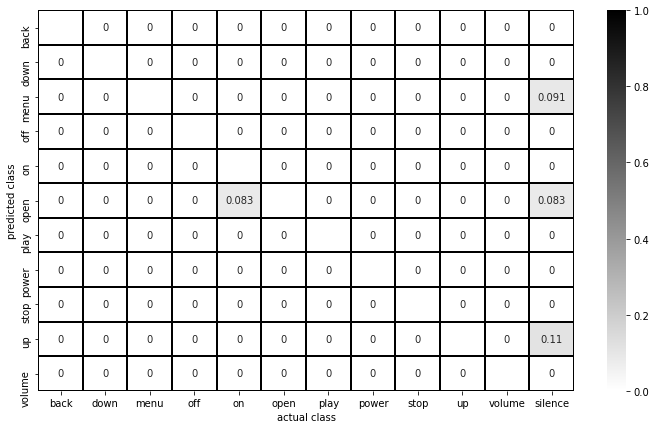

----------
speaker4 - test loss : 0.580 - test accuracy : 0.864
Threshold : 0.5


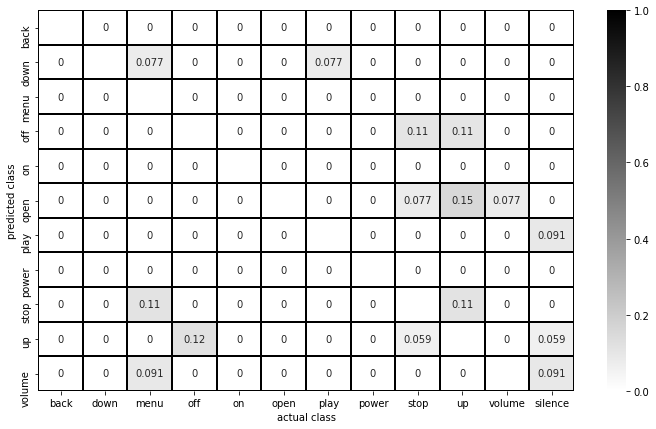

Threshold : 0.6


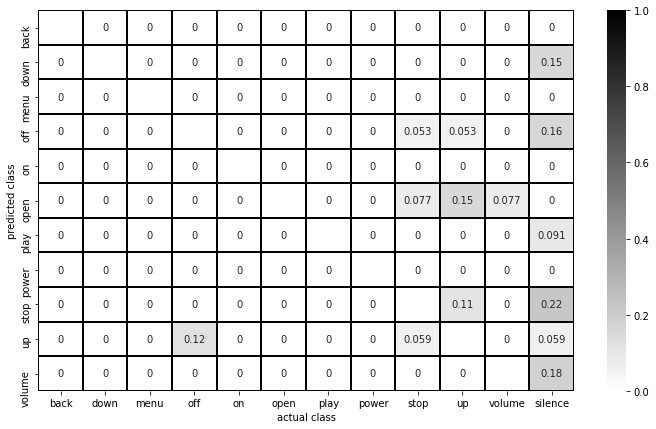

Threshold : 0.7


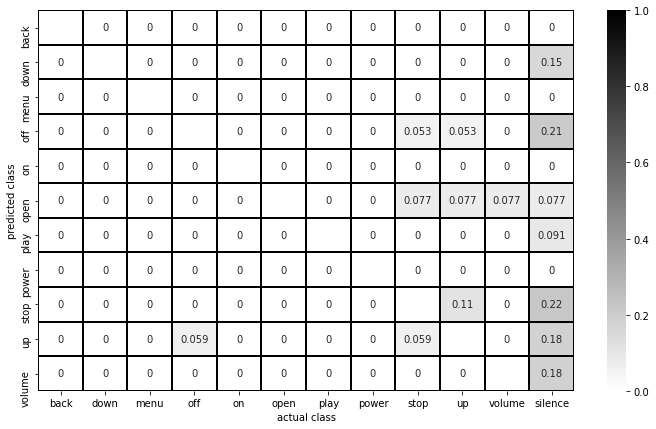

Threshold : 0.8


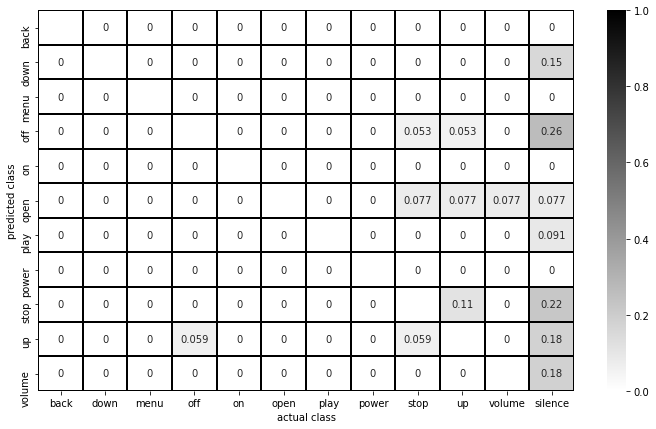

----------
speaker5 - test loss : 0.049 - test accuracy : 0.982
Threshold : 0.5


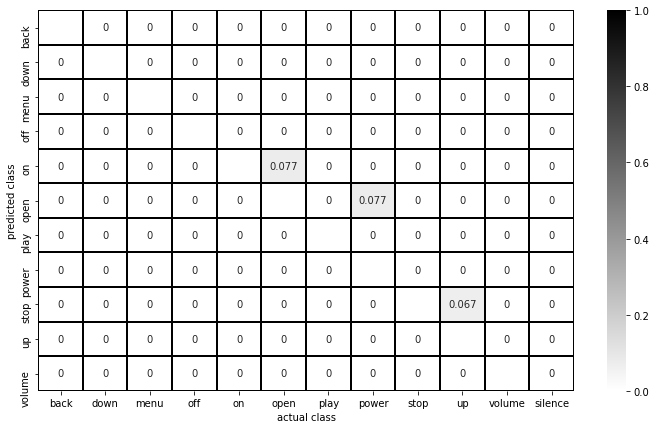

Threshold : 0.6


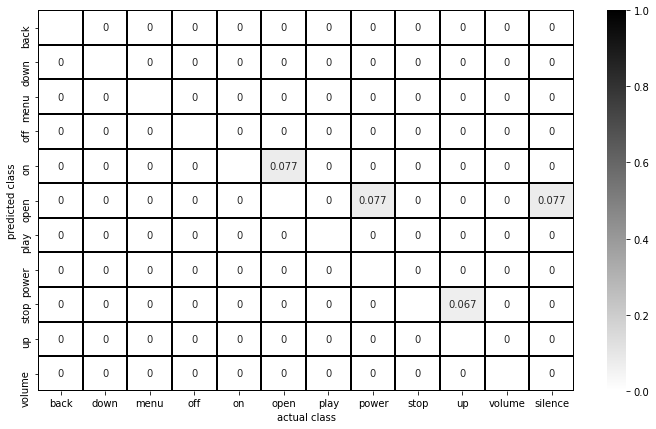

Threshold : 0.7


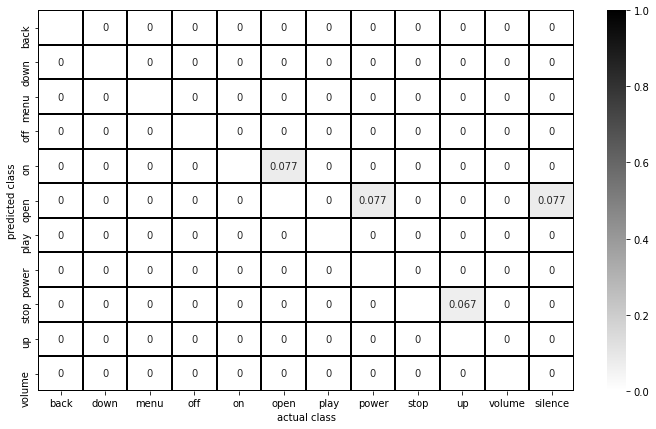

Threshold : 0.8


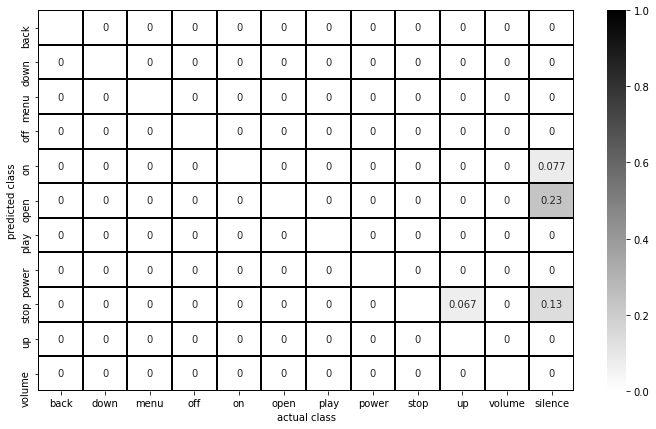

----------
speaker6 - test loss : 5.845 - test accuracy : 0.224
Threshold : 0.5


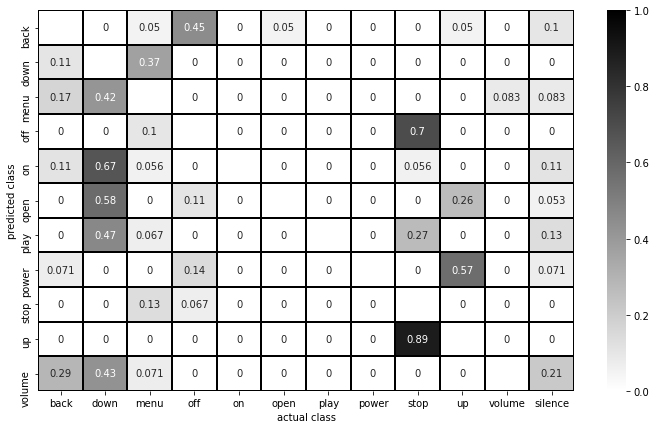

Threshold : 0.6


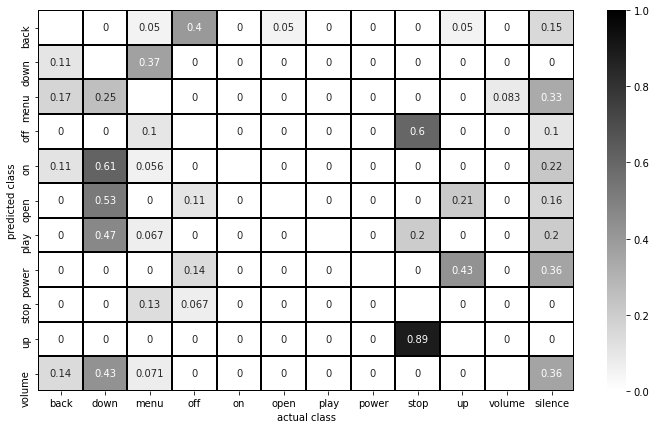

Threshold : 0.7


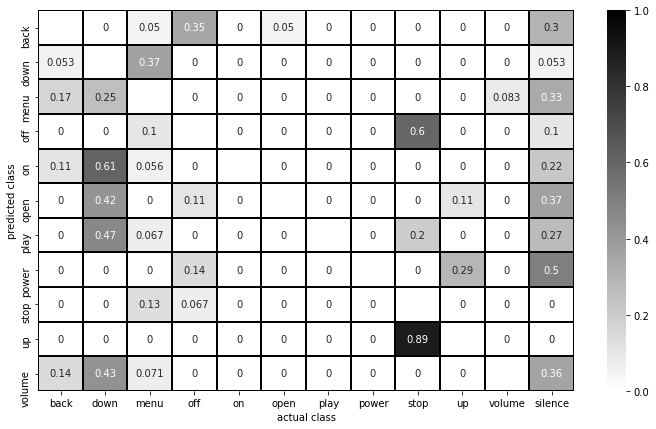

Threshold : 0.8


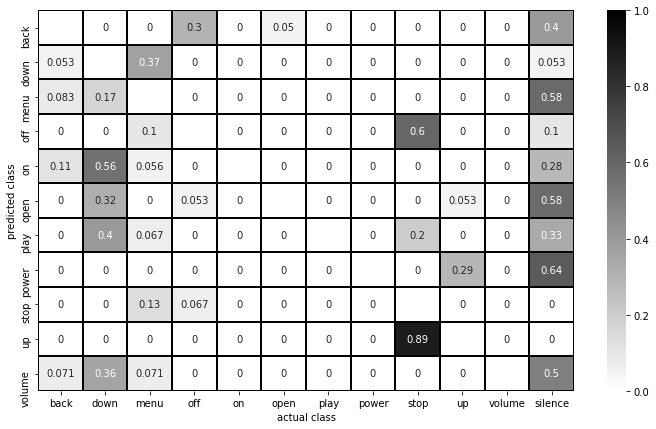

----------
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : 

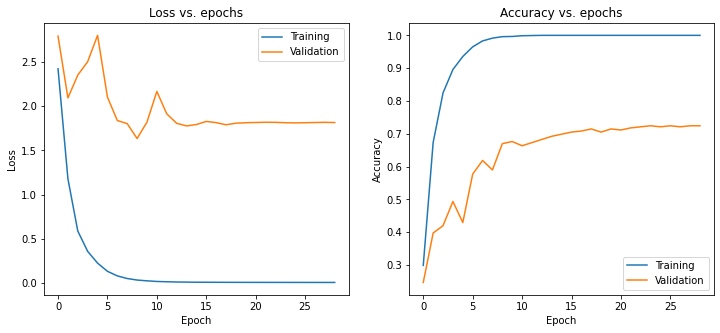

---Testing stage---
speaker1 - test loss : 0.127 - test accuracy : 0.964
Threshold : 0.5


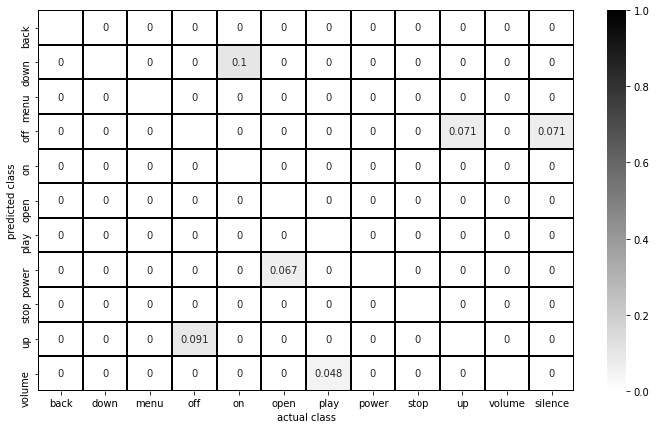

Threshold : 0.6


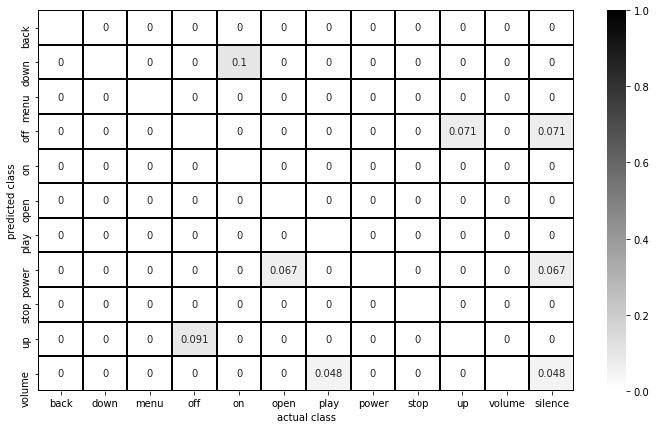

Threshold : 0.7


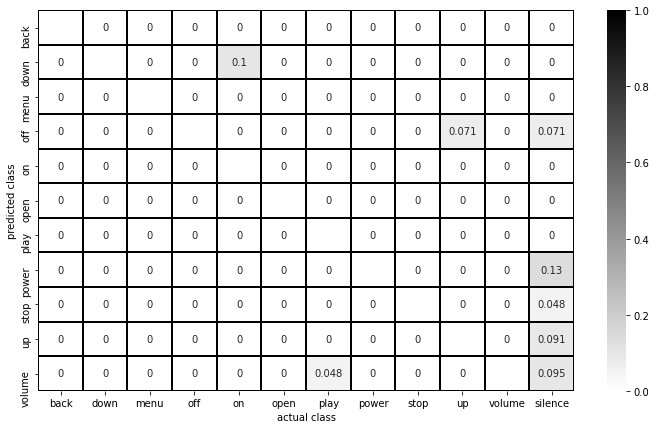

Threshold : 0.8


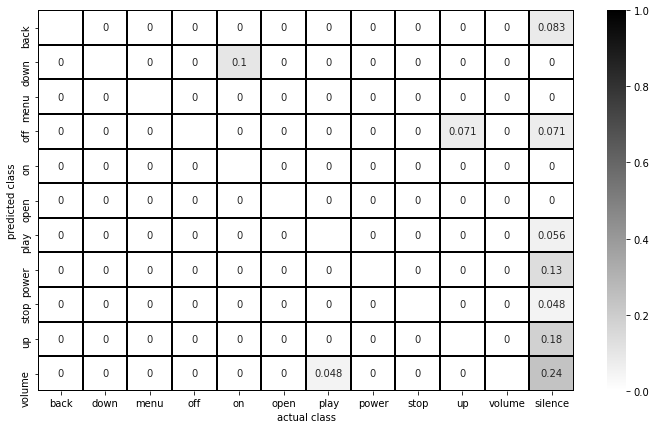

----------
speaker2 - test loss : 0.316 - test accuracy : 0.902
Threshold : 0.5


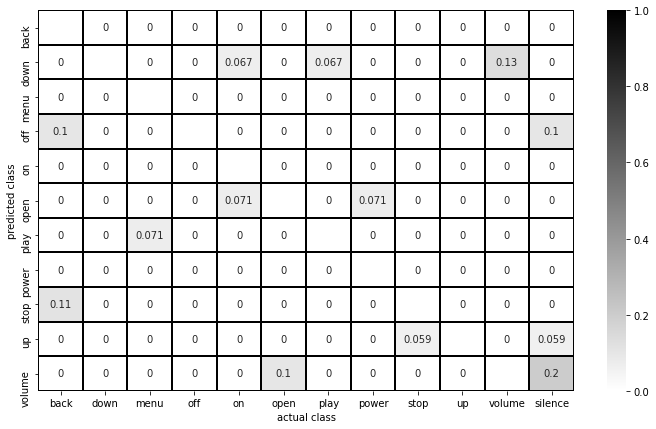

Threshold : 0.6


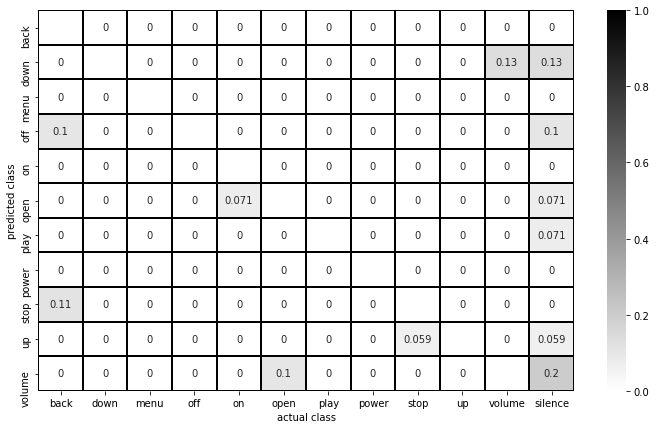

Threshold : 0.7


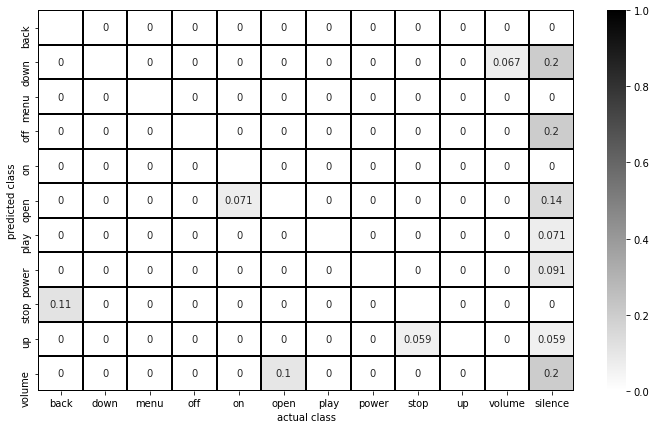

Threshold : 0.8


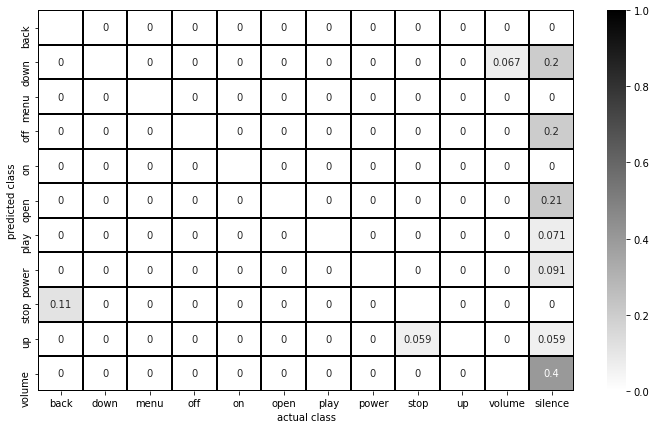

----------
speaker3 - test loss : 0.052 - test accuracy : 0.977
Threshold : 0.5


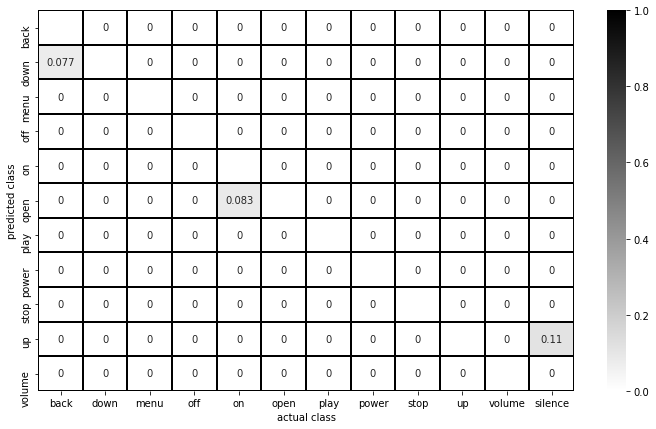

Threshold : 0.6


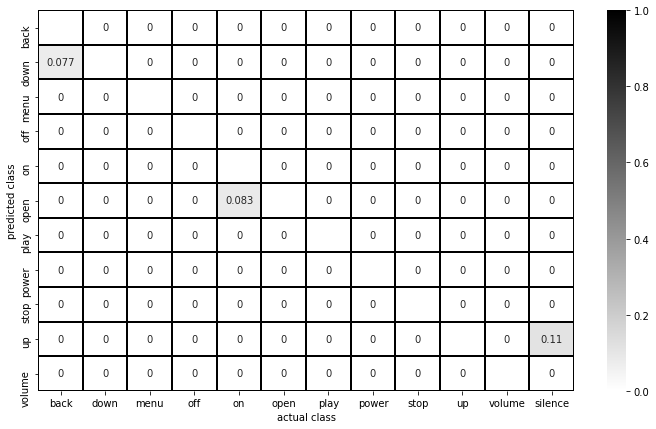

Threshold : 0.7


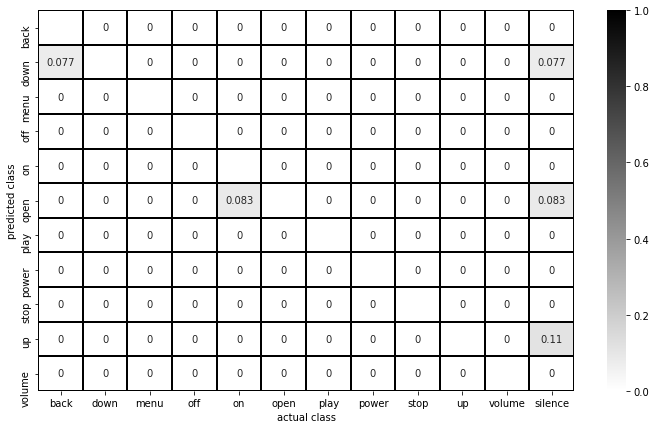

Threshold : 0.8


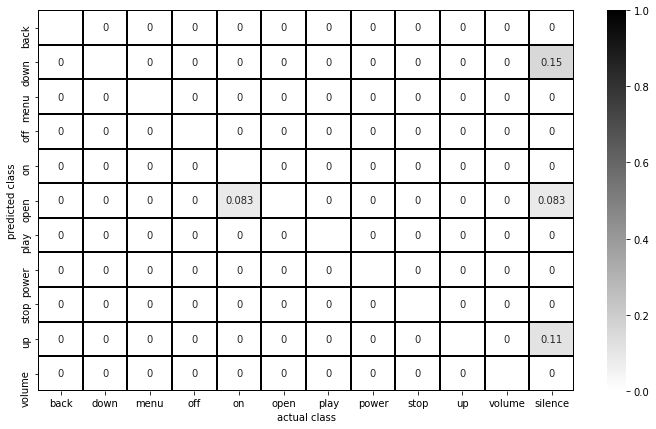

----------
speaker4 - test loss : 0.743 - test accuracy : 0.864
Threshold : 0.5


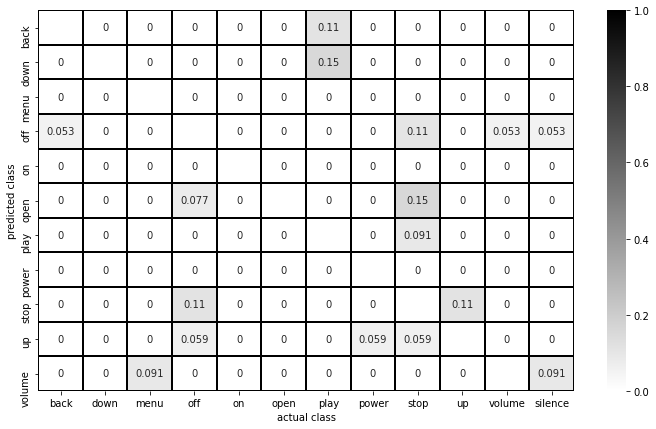

Threshold : 0.6


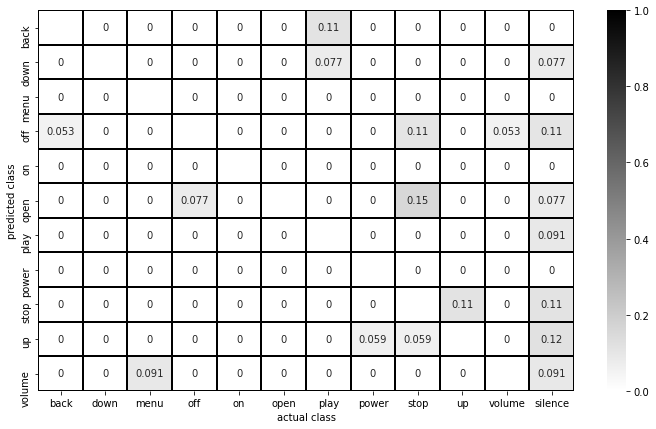

Threshold : 0.7


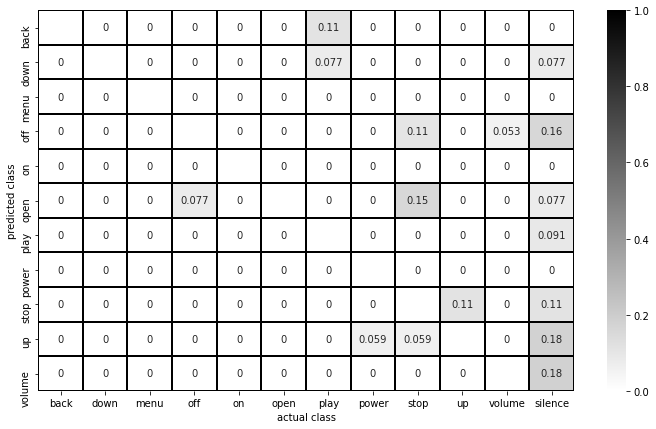

Threshold : 0.8


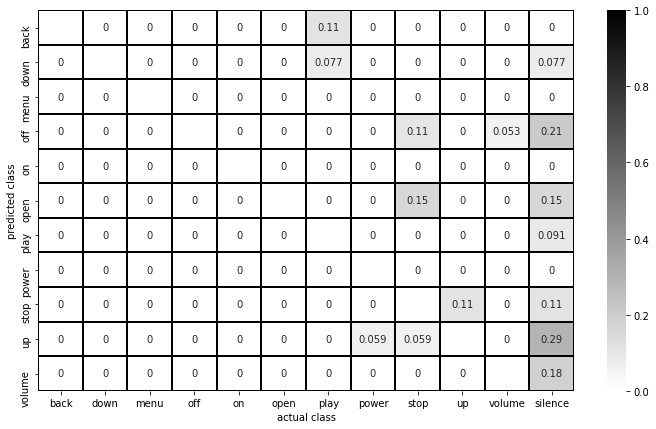

----------
speaker5 - test loss : 0.010 - test accuracy : 1.000
Threshold : 0.5


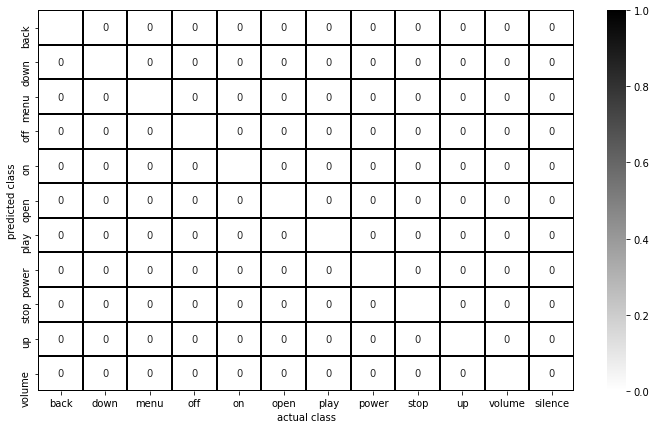

Threshold : 0.6


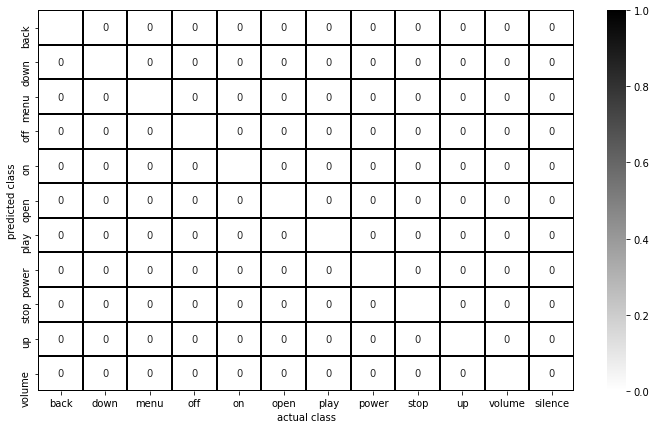

Threshold : 0.7


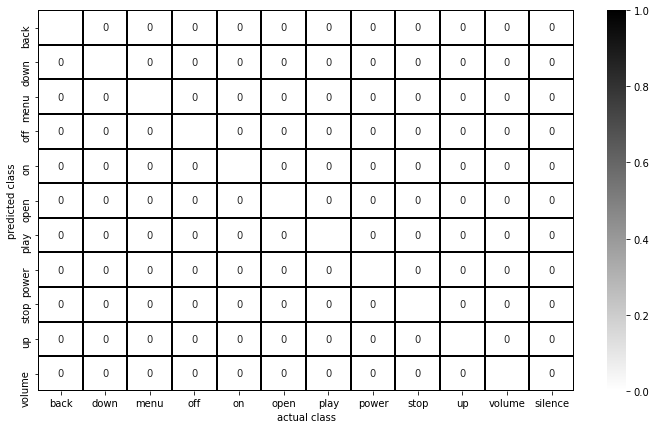

Threshold : 0.8


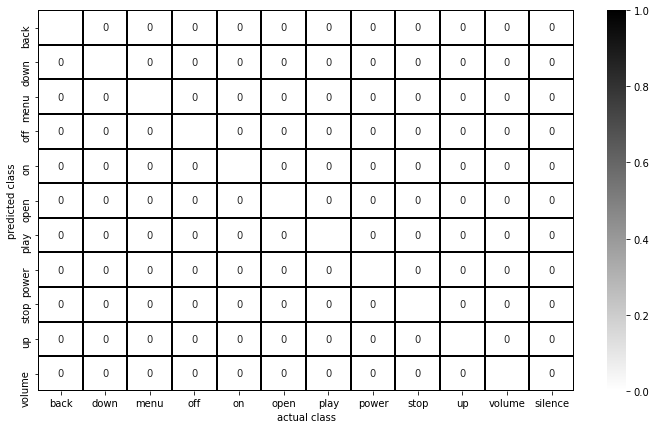

----------
speaker6 - test loss : 2.082 - test accuracy : 0.667
Threshold : 0.5


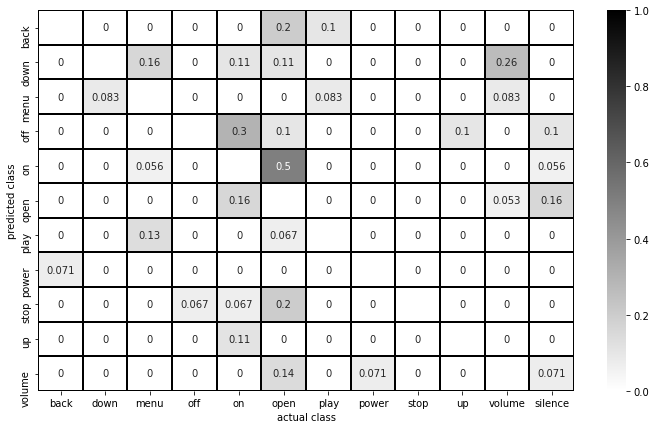

Threshold : 0.6


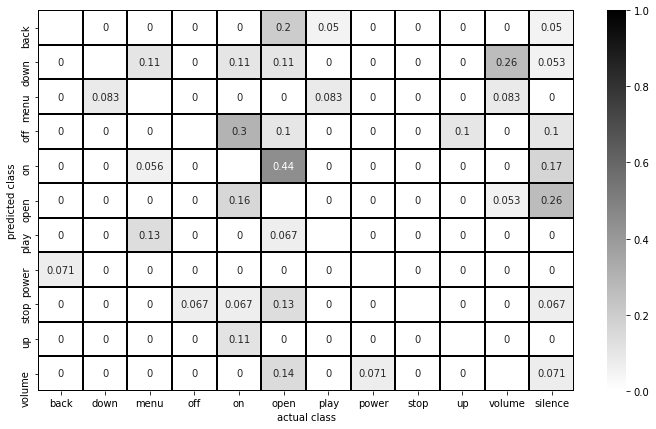

Threshold : 0.7


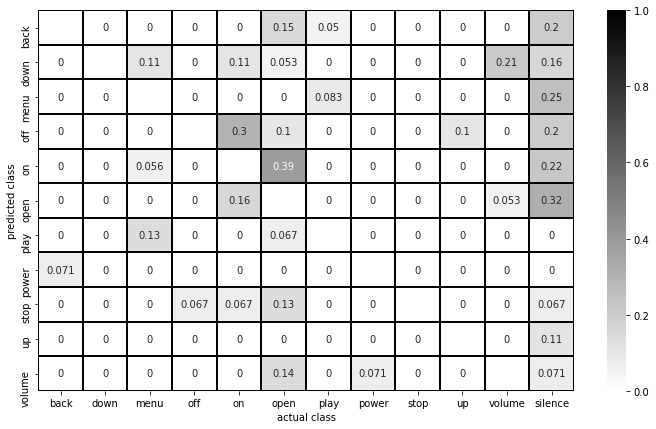

Threshold : 0.8


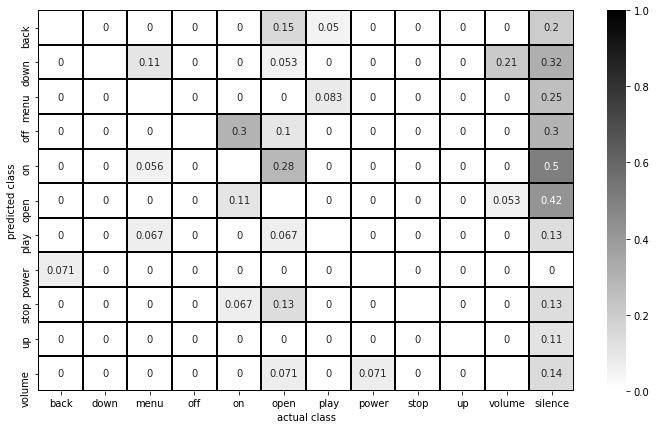

----------
Finished experiment.


In [8]:
for nn_type in ['cnn', 'mlp']:
    run_experiment(['speaker1'], all_speakers, nn_type, threshold_list, False)
    run_experiment(['speaker1','speaker2','speaker3','speaker4','speaker5'], all_speakers, nn_type, threshold_list)
    run_experiment(all_speakers, all_speakers, nn_type, threshold_list)

In [12]:
cnn_cols = ['train_data', 'test_speaker', 'cnn_loss', 'cnn_accuracy']
mlp_cols = ['train_data', 'test_speaker', 'mlp_loss', 'mlp_accuracy']
cnn_df = pd.DataFrame(cnn_test_summary, columns=cnn_cols)
mlp_df = pd.DataFrame(mlp_test_summary, columns=mlp_cols)
final_df = cnn_df.merge(mlp_df, how='inner')
pd.set_option('display.max_colwidth', None)
display(final_df)

TypeError: unhashable type: 'list'